In [35]:
import os
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, PReLU, Linear, Conv2d, LSTM, Dropout
import torchaudio

from sklearn.metrics import accuracy_score, confusion_matrix

from loguru import logger

## Load configurations

In [2]:
def update_cfg():
    with initialize(config_path="./"):
        cfg = compose('config.yaml')
    return cfg

cfg = update_cfg()

## Data checking

torch.Size([67277]) 16000
tensor([-0.0731, -0.0750, -0.0746, -0.0750, -0.0750, -0.0759, -0.0750, -0.0750,
        -0.0746, -0.0753, -0.0746, -0.0750, -0.0756, -0.0753, -0.0750, -0.0743,
        -0.0753, -0.0759, -0.0756, -0.0762])
0: h# 0.150625
1: sh 0.29375
2: iy 0.3975
3: hv 0.485625
4: ae 0.6575
5: dcl 0.750625
6: jh 0.788125
7: axr 0.9175
8: dcl 1.053125
9: d 1.066875
10: aa 1.2308125
11: r 1.3175
12: kcl 1.44125
13: k 1.455
14: s 1.59625
15: ux 1.7725
16: tcl 1.8525
17: t 1.884375
18: ih 1.9425
19: n 2.01925
20: gcl 2.07125
21: g 2.095625
22: r 2.152875
23: iy 2.250625
24: z 2.350625
25: iy 2.415125
26: w 2.556125
27: ao 2.7035625
28: r 2.758375
29: sh 3.058125
30: epi 3.195
31: w 3.2458125
32: ao 3.3475
33: dx 3.3725
34: axr 3.5364375
35: ao 3.69575
36: l 3.7775
37: y 3.8471875
38: ih 3.949
39: axr 4.0375


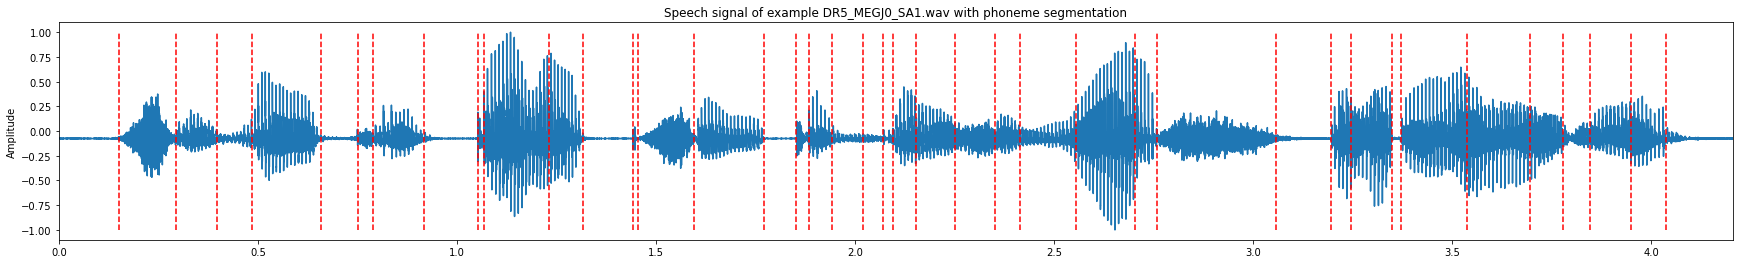

In [3]:
# Load data
signalData, samplingFrequency = torchaudio.load(cfg.wav_path, normalize=False)
signalData = signalData[0]

# Normalize data
signalData = 2 * (signalData - torch.min(signalData)) / (torch.max(signalData) - torch.min(signalData)) - 1 

print(signalData.shape, samplingFrequency)
print(signalData[:20])

# Read phoneme segmentation and annotation
with open(cfg.phn_path, 'r') as fp:
    lines = fp.readlines()
    lines = list(map(lambda line: line.split(" "), lines))

times = list(map(lambda line: int(line[1]), lines))[:-1]
labels = list(map(lambda line: line[2].strip(), lines))[:-1]

for i, (label, time) in enumerate(zip(labels, times)):
    print(f'{i}:', label, time / samplingFrequency)

x = np.array(list(range(len(signalData)))) / samplingFrequency
x_end = len(signalData) / samplingFrequency

plt.figure(figsize=(30, 4))
plt.title(f'Speech signal of example {cfg.file_name}.wav with phoneme segmentation')
plt.plot(x, signalData)
plt.xlim((0.0, x_end))
plt.ylabel('Amplitude')
for time in times:
    plt.vlines(time / samplingFrequency, -1, 1, colors = "r", linestyles = "dashed")
plt.show()

## Data Processing

In [3]:
from data_processing import TimitDataset, print_list, collate_fn_pad

In [6]:
def test_dataloader(cfg):
    if_dev_run = cfg.dev_run
    cfg.dev_run = True
    spect, _, _, _, phoneme_labels, _ = TimitDataset('C:/Users/Xianda/Downloads', cfg).process_file(cfg.wav_path)
    print(spect.shape, phoneme_labels.shape)
    # print(spect[:5])
    print_list(phoneme_labels.argmax(1), 25)

    # TimitDataset(os.path.join(cfg.dataset_path, 'train'), cfg)

    # print(cfg.ckpt_path)
    cfg.dev_run = if_dev_run

cfg = update_cfg()
test_dataloader(cfg)

2022-05-26 21:17:08.134 | INFO     | data_processing:__init__:77 - Loading 0 files into cache ...
0it [00:00, ?it/s]


(421, 13, 9) (421, 39)
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 
33, 33, 33, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
23, 23, 23, 23, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4, 
 4,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
30, 30, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 31, 
31, 31, 10, 10, 10, 10, 10, 34, 34, 34,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20, 20, 20, 20, 20, 20, 20, 

## Model Definition

In [31]:
class CNN_Classifier(Module):
    def __init__(self, hparams):
        super(CNN_Classifier, self).__init__()
        self.hparams = hparams

        self.weight_layer = Linear(hparams.input_dim, hparams.input_dim, bias=False)

        self.encoder = Sequential(
            Conv2d(1, hparams.z_dim, kernel_size=(hparams.k_1_h, hparams.k_1_w)),
            PReLU(),
            Conv2d(hparams.z_dim, hparams.z_dim * 2, kernel_size=(hparams.k_2_h, hparams.k_2_w)),
            PReLU()
        )

        self.fc_1 = Sequential(
            Linear(hparams.fc_1_input, hparams.fc_1_hidden_1),
            PReLU(),
            Dropout(hparams.fc_2_dropout),
            Linear(hparams.fc_1_hidden_1, hparams.fc_1_hidden_2),
            PReLU(),
        )

        self.rnn = LSTM(hparams.fc_1_hidden_2, hparams.rnn_hidden, batch_first=True)
        self.rnn_hidden = self.init_hidden()

        self.fc_2 = Sequential(
            Linear(hparams.fc_2_input, hparams.fc_2_hidden_1),
            PReLU(),
            Dropout(hparams.fc_2_dropout),
            Linear(hparams.fc_2_hidden_1, hparams.fc_2_hidden_2),
            PReLU(),
            Dropout(hparams.fc_2_dropout),
            Linear(hparams.fc_2_hidden_2, hparams.n_classes),
        )

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hparams.rnn_hidden).to(self.hparams.device),
                torch.zeros(1, 1, self.hparams.rnn_hidden).to(self.hparams.device))

    def detach_hidden(self):
        for h in self.rnn_hidden:
            h.detach_()

    def forward(self, spect):
        weighted = self.weight_layer(spect)

        encoded = self.encoder(weighted.unsqueeze(1))
        encoded = torch.flatten(encoded, 1)

        fc_1_out = self.fc_1(encoded)

        rnn_input = fc_1_out.unsqueeze(0)
        rnn_out, self.rnn_hidden = self.rnn(rnn_input, self.rnn_hidden)
        rnn_out = rnn_out.squeeze()

        cls_out = self.fc_2(rnn_out)

        return cls_out

In [8]:
cfg = update_cfg()
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

device = cfg.device
cfg.device = 'cpu'

input_data = torch.randn(246, 13, 9)

# conv1 = Conv2d(1, cfg.z_dim, kernel_size=(cfg.k_1_h, cfg.k_1_w))
# conv2 = Conv2d(cfg.z_dim, cfg.z_dim * 2, kernel_size= (cfg.k_2_h, cfg.k_2_w))

# conv1_output = conv1(input_data.unsqueeze(1))
# print(conv1_output.shape)
# conv2_output = conv2(conv1_output)
# print(conv2_output.shape)
# print(conv2_output.shape[1] * conv2_output.shape[2] * conv2_output.shape[3])

model = CNN_Classifier(cfg)
out = model(input_data)
print(out.shape)

cfg.device = device

NVIDIA GeForce RTX 3080 Ti
torch.Size([246, 39])


## Training & Testing

In [36]:
def train_loop(epoch_i, dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    total_loss = 0
    with tqdm(total=size, desc=f'epoch {epoch_i}') as t:
        for i, (X, _, _, _, y_class, _) in enumerate(dataloader):
            optimizer.zero_grad()
            model.hidden = model.init_hidden()
            model.detach_hidden()

            output = model(X)
            loss = loss_fn(output, y_class)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix_str(f'loss={total_loss / (i + 1):>7.3f}')
            t.update()

    return total_loss / size

def get_img_from_logits(logits, cmap, alpha):
    img = np.ones((logits.shape[1], logits.shape[0], 4))
    for i, log in enumerate(logits):
        img[:, i, :3] = np.transpose(np.array([log]).transpose(1, 0) * cmap, (1, 0)).transpose(1, 0)
        # img[:, i, :3] *= cmap
        img[:, i, -1] = log ** 2
    return img

def print_val(file_name, targets, labels, preds, logits):
    cmp_arr = [x == y for x, y in zip(targets, preds)]
    non_sil_cmp_arr = [x for x, y in zip(cmp_arr, targets) if y != 10]
    print("Wav File:", file_name, f"Accuracy: {sum(cmp_arr) / len(cmp_arr) * 100:2.2f}%", f"Non-sil Accuracy: {sum(non_sil_cmp_arr) / len(non_sil_cmp_arr) * 100:2.2f}%")
    print("Ground Truth:")
    print_list(targets)
    print("Prediction:")
    print_list(preds)

    figs, axes = plt.subplots(2, sharex=True, figsize=(300, 39))

    axes[0].set_title('Ground Truth')
    axes[0].imshow(labels.transpose(1, 0), cmap='jet')
    axes[1].set_title('Prediction')
    axes[1].imshow(logits.transpose(1, 0), cmap='jet')
    plt.show()

def validate(dataloader, model, loss_fn):
    size = len(dataloader)
    val_loss = 0
    pred_list, logits_list, target_list, label_list, wav_list = [], [], [], [], []

    with torch.no_grad():
        for X, _, _, _, y_class, wav_file in dataloader:
            model.hidden = model.init_hidden()
            output = model(X)
            val_loss += loss_fn(output, y_class).item()
            pred, gt = output.argmax(1), y_class.argmax(1)
            logits_list.append(output.cpu().numpy())
            label_list.append(y_class.cpu().numpy())
            pred_list.append(pred.tolist())
            target_list.append(gt.tolist())
            wav_list.append(wav_file)

    val_loss /= size
    val_acc = report_func(target_list, pred_list)

    logger.info(f"Val Result: Avg loss: {val_loss:>4.3f} Accuracy: {(100*val_acc):>4.1f}%")

    idx = np.random.randint(0, size)
    print_val(wav_list[idx].rsplit('\\', 1)[1], target_list[idx], label_list[idx], pred_list[idx], logits_list[idx])

    return val_loss, val_acc, pred_list, target_list

def report_func(pred, target):
    batch_size = len(pred)
    acc= 0

    for i in range(batch_size):
        acc += accuracy_score(target[i], pred[i])

    acc /= batch_size

    return acc

In [6]:
cfg = update_cfg()
torch.cuda.set_device(cfg.device_id)

if not os.path.exists(cfg.output_path):
    os.makedirs(cfg.output_path, exist_ok=True)

### Train

#### Load train Data

In [11]:
cfg = update_cfg()
train_dataset, val_dataset = TimitDataset.get_train_dataset(cfg.dataset_path, cfg)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_pad, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn_pad)

2022-05-26 21:17:57.355 | INFO     | data_processing:__init__:77 - Loading 4620 files into cache ...
100%|██████████| 4620/4620 [10:04<00:00,  7.64it/s]


#### Run train loop

2022-05-26 21:59:10.164 | INFO     | __main__:<module>:10 - Model initiated.
2022-05-26 21:59:10.165 | INFO     | __main__:<module>:12 - Training started.


----------------------------


epoch 0: 100%|██████████| 4158/4158 [01:38<00:00, 42.18it/s, loss=  1.452]
2022-05-26 22:00:51.597 | INFO     | __main__:validate:71 - Val Result: Avg loss: 1.181 Accuracy: 64.3%


Wav File: DR6_MEJL0_SX332.WAV Accuracy: 69.02% Non-sil Accuracy: 60.75%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 
17, 17, 11, 11, 11, 11, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 22, 22, 22, 22, 10, 10, 10, 10, 
10, 10, 35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 
17, 17, 17, 17, 17, 17,  4,  4,  4,  4,  4,  4,  4,  4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 32, 32, 32, 32, 20, 20, 
20, 20, 20, 20, 20, 20,  8,  8,  8,  8,  8,  8,  8,  8, 27, 27, 27, 27, 27, 27, 10, 10, 10, 10, 34, 
34,  0,  0,  0,  0,  0,  0,  0,  0, 32, 32, 32, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 26, 
26, 26, 26, 26, 26, 22, 22, 22, 22, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9, 12, 12, 12, 12, 12, 12, 
12, 1

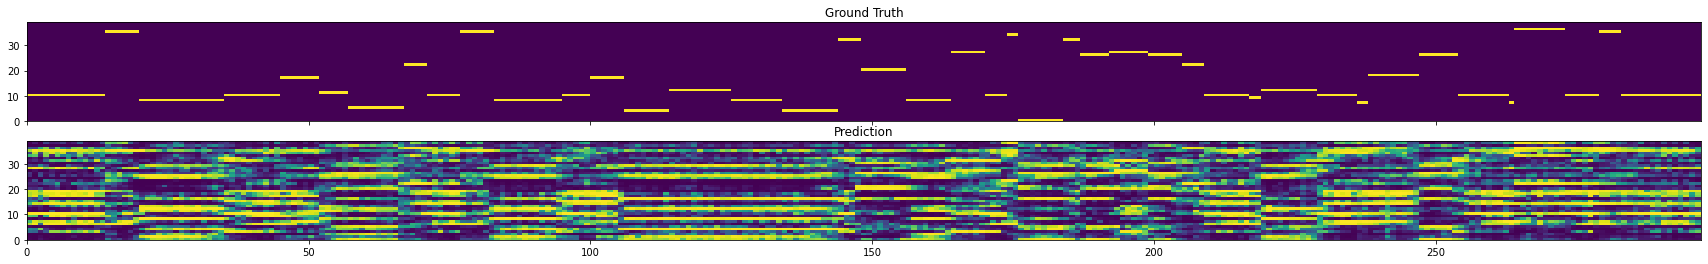

epoch 1: 100%|██████████| 4158/4158 [01:41<00:00, 41.03it/s, loss=  1.104]
2022-05-26 22:02:36.062 | INFO     | __main__:validate:71 - Val Result: Avg loss: 1.055 Accuracy: 67.9%


Wav File: DR6_FKLC1_SA2.WAV Accuracy: 83.39% Non-sil Accuracy: 77.83%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 24, 24, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 10, 10, 10, 10, 10, 10,  3,  3,  3,  3, 26, 26, 26, 26, 26, 26, 26, 32, 32, 32, 26, 
26, 26, 26, 26, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7, 29, 29, 29, 29, 29, 29, 
29, 29, 29,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 26, 31, 31, 
31, 31, 31, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2,  2,  2, 11, 11, 11, 11, 11, 11, 20, 20, 20, 20, 20, 20, 20, 20, 20,  4,  4,  4,  4,  4,  4,  4, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 10, 34, 34, 34, 
11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 
19, 29,

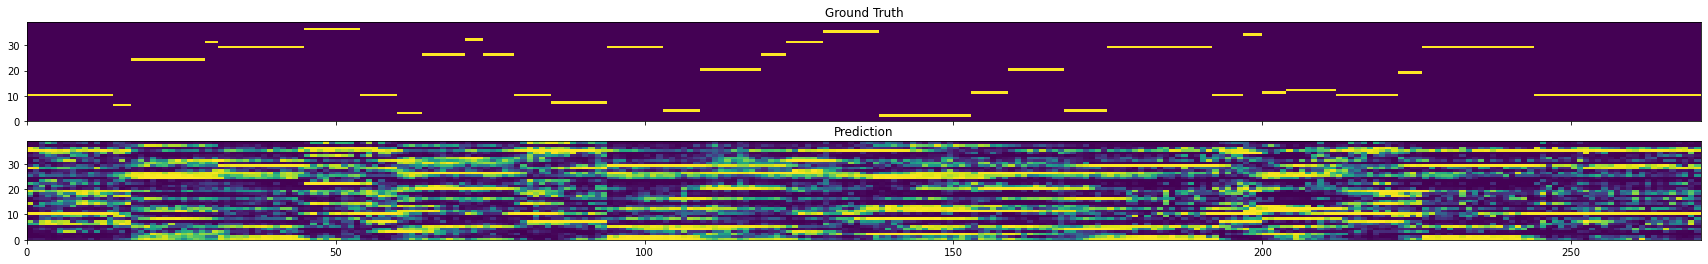

epoch 2: 100%|██████████| 4158/4158 [01:40<00:00, 41.32it/s, loss=  0.995]
2022-05-26 22:04:19.730 | INFO     | __main__:validate:71 - Val Result: Avg loss: 1.006 Accuracy: 69.2%


Wav File: DR7_MGAK0_SA1.WAV Accuracy: 86.43% Non-sil Accuracy: 88.64%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 
33, 33, 33, 33, 20, 20, 20, 20, 28, 28, 28, 28, 28, 28, 28, 28, 28,  0,  0,  0,  0,  0,  0,  0,  0, 
10, 10, 10,  6,  6,  6, 21, 21, 21, 21, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10,  6,  6,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4, 10, 10, 10,  7,  7,  7,  7,  7, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
30, 10, 10, 10, 10, 10, 10, 10, 10, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 34, 
34, 34, 34,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 10, 10, 10, 
10, 13,

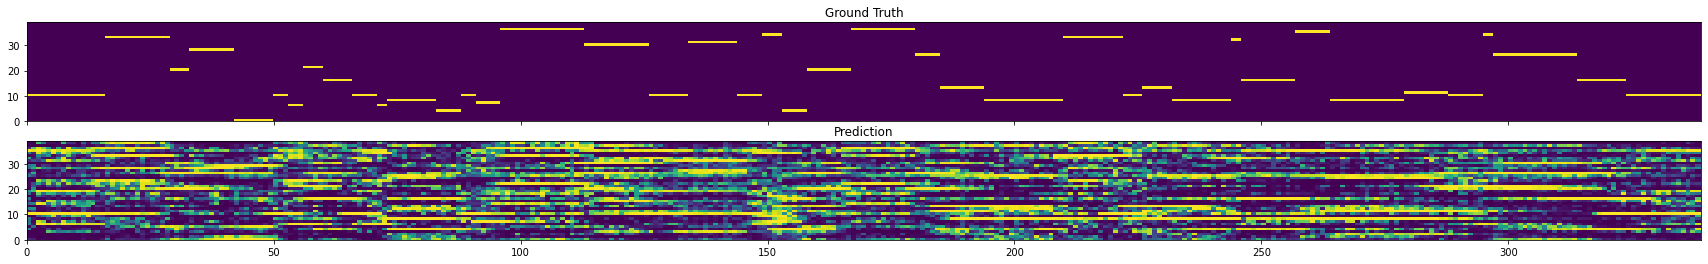

epoch 3: 100%|██████████| 4158/4158 [01:39<00:00, 41.82it/s, loss=  0.930]
2022-05-26 22:06:02.318 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.949 Accuracy: 70.6%


Wav File: DR3_FSJS0_SA1.WAV Accuracy: 85.81% Non-sil Accuracy: 83.93%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10,  6, 
 6,  6, 21, 21, 21, 21, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10,  6,  6,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10,  7,  7,  7, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
10, 10, 10, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 26, 26, 26, 31, 31, 31, 31, 31, 31, 31, 
10, 10,

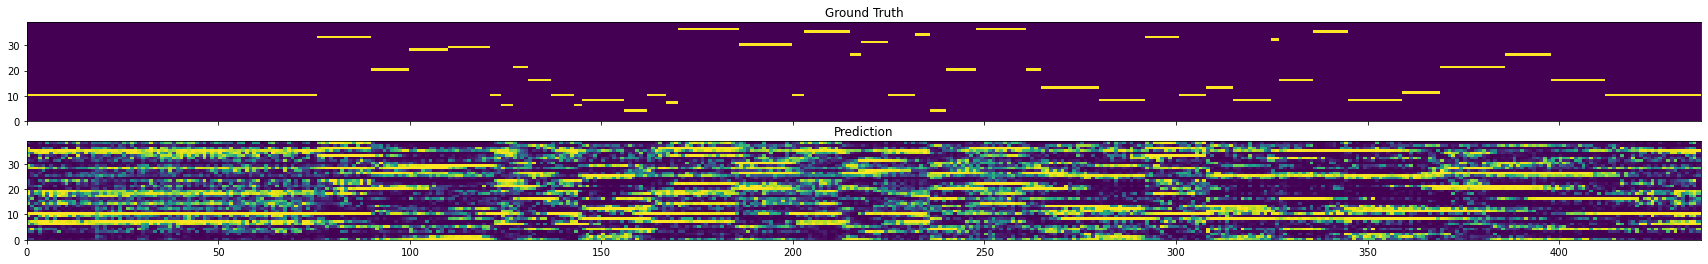

epoch 4: 100%|██████████| 4158/4158 [01:41<00:00, 41.08it/s, loss=  0.884]
2022-05-26 22:07:46.715 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.934 Accuracy: 71.3%


Wav File: DR3_MADC0_SX107.WAV Accuracy: 75.96% Non-sil Accuracy: 64.25%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
16, 14, 14, 10, 10, 10, 10, 10, 19, 19, 19, 19,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 
10, 10, 10, 10, 10, 17, 17, 17,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4, 32, 32, 32, 32, 
20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 25, 25, 25, 
25, 25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5,  5, 10, 10, 10, 10,  7,  7,  7, 36, 36, 36, 36, 36, 36, 36, 26, 26, 26, 31, 31, 31, 
31, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 36, 36, 36, 36, 36, 36, 10, 
10, 10,  7,  7,  7,  7,  7,  7,  7,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20,  

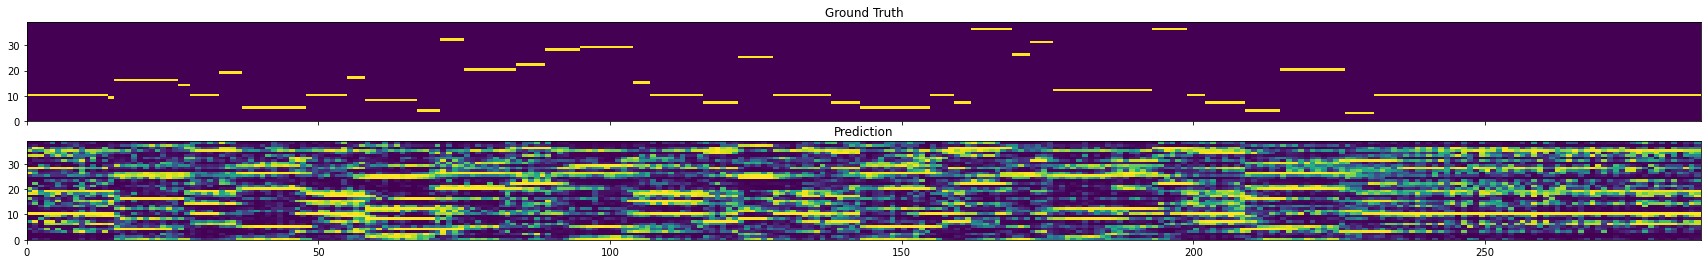

epoch 5: 100%|██████████| 4158/4158 [01:41<00:00, 40.92it/s, loss=  0.841]
2022-05-26 22:09:31.391 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.938 Accuracy: 71.1%


Wav File: DR4_MJAC0_SX307.WAV Accuracy: 67.00% Non-sil Accuracy: 55.63%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 26, 26, 26,  3,  3,  3,  3,  3,  3, 
 3,  3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 32, 32, 20, 20, 20, 20, 20, 20, 
20, 20, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 
31, 31, 31, 31, 31, 31, 31, 31,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 
 1,  1,  1,  1,  1,  1, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 23, 23, 23, 23, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
16, 16, 16, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10,  6,  6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19,  9, 26, 26, 26, 26, 31, 3

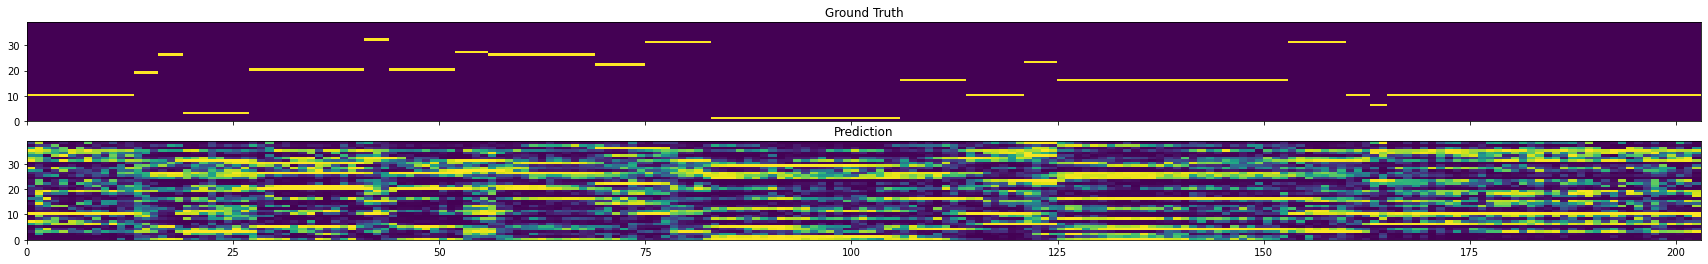

epoch 6: 100%|██████████| 4158/4158 [01:40<00:00, 41.52it/s, loss=  0.811]
2022-05-26 22:11:14.616 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.919 Accuracy: 71.9%


Wav File: DR4_MJJJ0_SI1793.WAV Accuracy: 72.15% Non-sil Accuracy: 65.59%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 26, 26, 26, 26, 26, 26, 26, 36, 
36, 36, 36, 36, 36, 36, 36, 18, 18, 18, 18, 18, 18, 18, 18,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 34, 34, 34, 34, 34, 
34,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15, 15, 15, 15, 26, 26, 26, 31, 
31, 31, 31, 31, 10, 10, 10, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 
10, 10, 13, 13, 13, 13, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 22, 22, 31, 31, 31, 31, 31, 
31,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 25, 
25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 31, 31, 
31, 31, 31, 11, 11, 11, 11, 11,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4, 
10, 

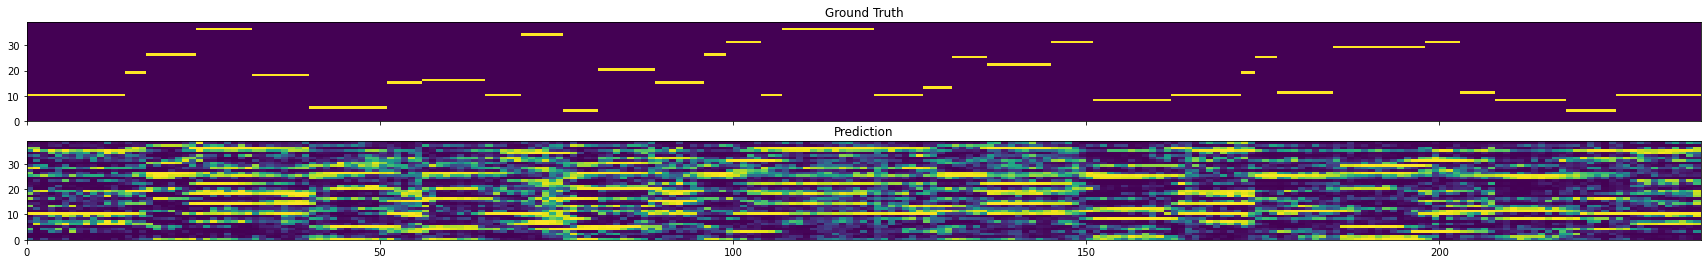

epoch 7: 100%|██████████| 4158/4158 [01:41<00:00, 40.91it/s, loss=  0.783]
2022-05-26 22:12:59.381 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.941 Accuracy: 71.6%


Wav File: DR5_FCDR1_SX286.WAV Accuracy: 64.22% Non-sil Accuracy: 58.72%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 26, 26, 26, 26, 26, 26, 26, 31, 31, 31, 
31, 31, 31, 35, 35, 35, 35, 35, 35, 35, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
 0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 
20, 20,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 23, 23, 23, 23, 23, 16, 16, 16, 16, 16, 10, 10, 10, 
10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7, 11, 11, 11, 11, 11, 11, 24, 24, 24, 24, 24, 
24, 24, 24, 24, 24, 24, 15, 15, 15, 15, 15, 15, 15, 15, 15, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 
11, 11, 11, 11, 11, 11, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 18, 
18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 10, 10, 10, 10, 10, 10, 35, 35, 
35, 3

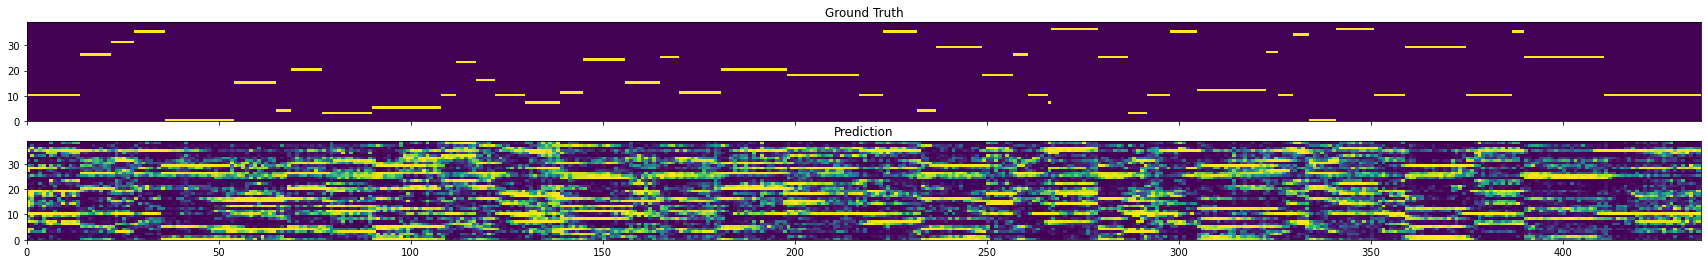

epoch 8: 100%|██████████| 4158/4158 [01:40<00:00, 41.40it/s, loss=  0.758]
2022-05-26 22:14:42.958 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.931 Accuracy: 71.7%


Wav File: DR2_FRLL0_SA2.WAV Accuracy: 90.21% Non-sil Accuracy: 88.00%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 24, 24, 24, 31, 31, 31, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 32, 32, 32, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 
26, 26, 26, 26, 26,  4,  4,  4,  4,  4,  4, 26, 26, 26, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 
31, 26, 26, 26, 26, 26, 35, 35, 35, 35, 35, 35, 35,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2,  2,  2,  2,  2, 11, 11, 11, 11, 20, 20, 20, 20, 20, 20, 20, 20, 20,  4,  4,  4,  4,  4,  4,  4, 
 4,  4, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 
10, 10, 34, 34, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 
10,  7,

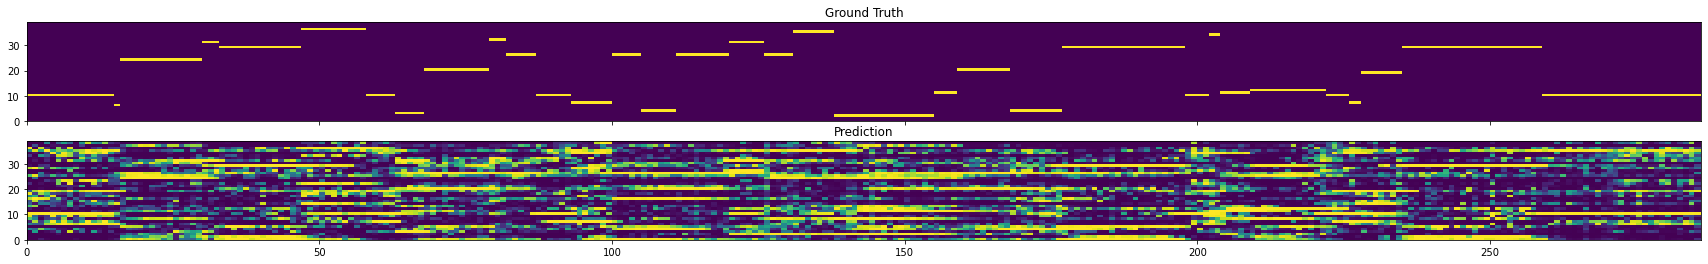

epoch 9: 100%|██████████| 4158/4158 [01:41<00:00, 41.01it/s, loss=  0.737]
2022-05-26 22:16:27.571 | INFO     | __main__:validate:71 - Val Result: Avg loss: 0.905 Accuracy: 72.4%


Wav File: DR3_MSFV0_SI1892.WAV Accuracy: 54.18% Non-sil Accuracy: 40.00%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 21, 21, 30, 30, 30, 30, 30, 30, 10, 10, 10, 
10,  7,  7, 37, 37, 37, 37, 37, 37, 37, 37, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 31, 31, 31, 31, 10, 10, 10,  6,  6,  1,  1,  1, 
 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 31, 31, 31, 31, 31, 19, 19, 25, 25, 25, 25, 25, 25, 25, 
25, 25, 36, 36, 36, 36, 36, 36, 36, 28, 28, 28, 28, 28, 28, 28, 28, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 24, 11, 11, 11, 11, 11,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1, 
 1,  1,  1,  1,  1, 31, 31, 31, 10, 10, 10, 10, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 
12, 12, 10, 10, 13, 13, 13, 13, 13, 25, 25, 25, 25, 25, 25, 19, 19, 19, 19, 19, 25, 25, 25, 25, 18, 
18, 

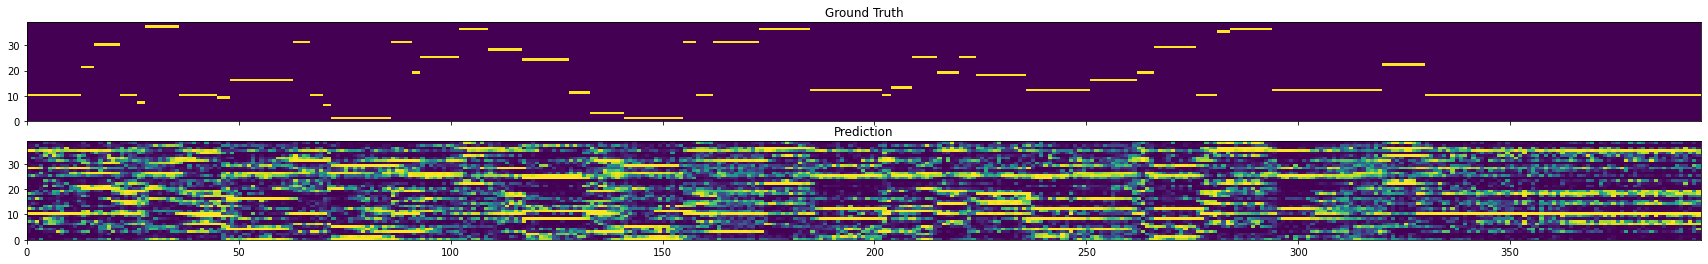

In [15]:
cfg = update_cfg()
model = CNN_Classifier(cfg).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

if os.path.exists(cfg.ckpt_path) and cfg.re_train:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')
else:
    logger.info('Model initiated.')

logger.info('Training started.')
print('----------------------------')
results = []
for epoch in range(cfg.epochs):
    train_loss = train_loop(epoch, train_dataloader, model, loss, optimizer)
    val_loss, val_acc, _, _ = validate(val_dataloader, model, loss)
    results.append([epoch, train_loss, val_loss, val_acc])

if not cfg.dev_run:
    with open(cfg.report_path, 'w', encoding='utf-8') as fw:
        fw.writelines([','.join([str(i) for i in result]) + '\n' for result in results])
    torch.save(model.state_dict(), cfg.ckpt_path)

### Test

#### Load test data

In [7]:
test_dataset = TimitDataset.get_test_dataset(cfg.dataset_path, cfg)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_pad)

2022-05-26 22:25:40.092 | INFO     | data_processing:__init__:77 - Loading 1680 files into cache ...
100%|██████████| 1680/1680 [03:50<00:00,  7.29it/s]


#### Run test

2022-05-26 23:34:57.975 | INFO     | __main__:<module>:7 - Model loaded from checkpoint.
2022-05-26 23:35:09.249 | INFO     | __main__:validate:66 - Val Result: Avg loss: 0.908 Accuracy: 71.6%


Wav File: DR2_MWEW0_SX281.WAV Accuracy: 74.03% Non-sil Accuracy: 64.04%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 26, 26, 
26, 31, 31, 31, 31, 10, 10, 10, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,  4,  4,  4,  4,  4, 26, 
26, 26, 26, 26, 26, 26, 26, 33, 33, 33, 33, 33, 33, 33, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 
17, 11, 11, 11, 11, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 
35, 35, 35, 35, 35, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 
10, 10, 10, 13, 13, 13, 13, 26, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 20, 20, 
20, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 38, 38, 38, 38, 10, 10, 10, 10, 10, 10, 10, 10,  9, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 
22, 2

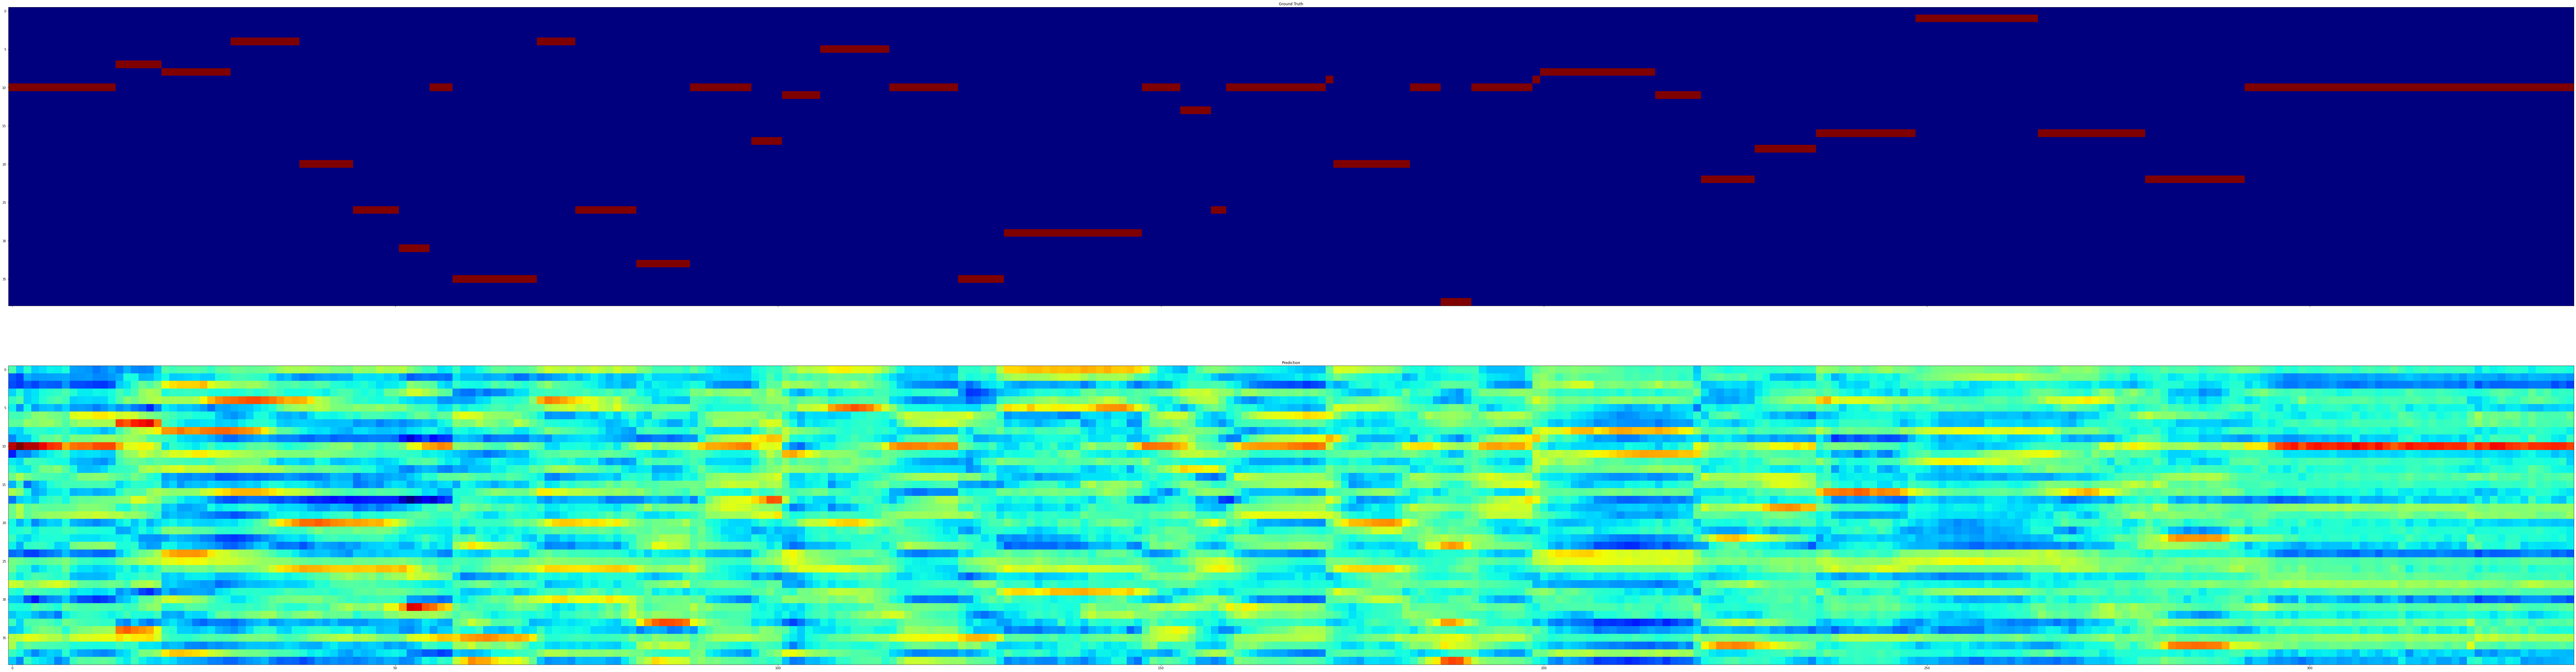

In [39]:
cfg = update_cfg()
model = CNN_Classifier(cfg).cuda()
if not os.path.exists(cfg.ckpt_path):
    logger.error('No available checkpoint file found, exiting ...')
else:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')
    model.eval()
    _, _, pred_list, target_list = validate(test_dataloader, model, torch.nn.CrossEntropyLoss())

In [40]:
pred_all, target_all = [], []

for pred, gt in zip(pred_list, target_list):
    pred_all += pred
    target_all += gt

print(np.shape(pred_all), np.shape(target_all))

(519453,) (519453,)


In [44]:
import json
with open(cfg.phn_idx_dict_path, 'r') as fp:
    phoneme2idx = json.load(fp)
idx2phoneme = {v:k for k, v in phoneme2idx.items()}

labels = []
for i in range(39):
    labels.append(idx2phoneme[i])

print(labels)

['eh', 'aw', 'oy', 'm', 'r', 'ey', 'd', 'k', 'ao', 'b', 'sil', 'el', 'ay', 'w', 'th', 'v', 'er', 'p', 'f', 'dh', 'iy', 'y', 'z', 'jh', 'ow', 'ah', 'ih', 'ng', 'hh', 'ae', 'uw', 'en', 'dx', 'sh', 'g', 't', 's', 'uh', 'ch']


In [46]:
cf_matrix = confusion_matrix(pred_all, target_all, normalize='true')
print(cf_matrix)

[[4.78989640e-01 1.38517053e-02 2.32801769e-04 ... 1.28040973e-03
  5.82004423e-03 0.00000000e+00]
 [2.92682927e-02 4.56097561e-01 9.75609756e-04 ... 4.87804878e-04
  0.00000000e+00 0.00000000e+00]
 [6.68002672e-03 4.45335115e-04 6.59986640e-01 ... 2.22667557e-04
  6.01202405e-03 2.22667557e-04]
 ...
 [1.63493779e-03 1.93975670e-04 1.10843240e-04 ... 7.50741264e-01
  5.54216200e-05 1.60722698e-03]
 [1.51515152e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.35353535e-01 0.00000000e+00]
 [1.57183276e-03 3.14366551e-04 0.00000000e+00 ... 5.97296448e-02
  6.28733103e-04 5.17447344e-01]]


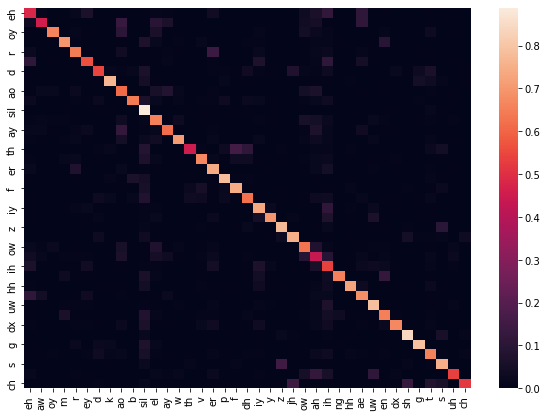

In [49]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cf_matrix, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm)
plt.show()

In [32]:
import time
input = torch.rand((1, 13, 9))
cfg = update_cfg()
model = CNN_Classifier(cfg)
model.load_state_dict(torch.load(cfg.ckpt_path))
model.eval()

start = time.time()
output = model(input)
end = time.time()

print(end - start)

0.0019996166229248047


In [34]:
import librosa
input = np.random.rand(4 * 160)
start = time.time()
output = librosa.feature.mfcc(input, 16000, n_mfcc=13, n_fft=160, hop_length=80, n_mels=40)
end = time.time()

print(end - start)
print(output.shape)

0.004000186920166016
(13, 9)
